No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.



First 5 rows of Reddit data:
        Date                                    Full_Discussion  \
0 2010-12-16  post ive never traded stock before but isnt no...   
1 2011-11-17  post bought amd at on full margin now its any ...   
2 2011-11-23  post i invested k in amd last week in my first...   
3 2012-01-21  post had amd for a few months how long do i ho...   
4 2012-10-13  post amd at an all time low advanced micro dev...   

   Discussion_Count  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  

Last 5 rows of Reddit data:
          Date                                    Full_Discussion  \
688 2024-11-08  post tsmc to suspend production of advanced ai...   
689 2024-11-10  post reuters exclusive us ordered tsmc to halt...   
690 2024-11-13  post amd to lay off of workforce or about empl...   
691 2024-11-15  post rstocks daily discussion fundamentals fri...   
692 2024-11-19  post i think my friend sold me my calls on sm

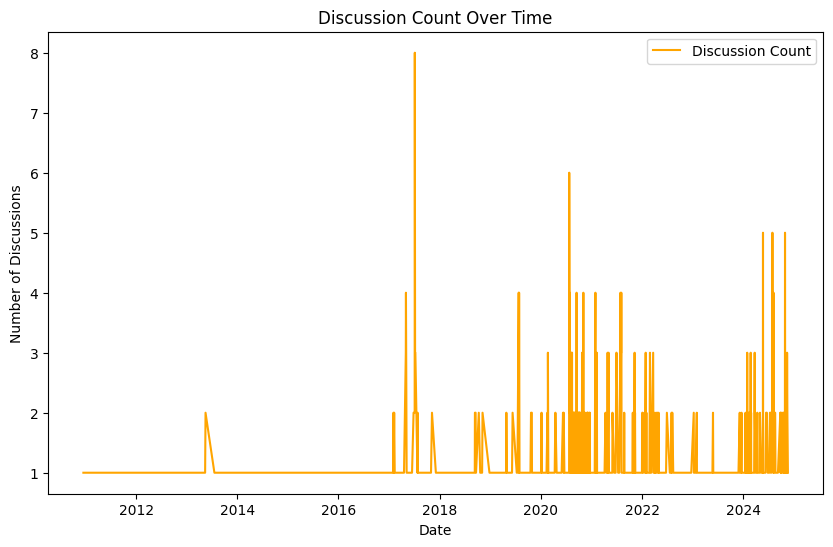


First 5 rows of Sentiment data:
        Date                                    Full_Discussion  \
0 2010-12-16  post ive never traded stock before but isnt no...   
1 2011-11-17  post bought amd at on full margin now its any ...   
2 2011-11-23  post i invested k in amd last week in my first...   
3 2012-01-21  post had amd for a few months how long do i ho...   
4 2012-10-13  post amd at an all time low advanced micro dev...   

   Discussion_Count  vader_compound  transformer_sentiment  negative  neutral  \
0                 1          0.9968                   -1.0     0.085    0.769   
1                 1         -0.9895                   -1.0     0.154    0.767   
2                 1          0.8468                   -1.0     0.050    0.796   
3                 1         -0.8857                   -1.0     0.140    0.757   
4                 1          0.9139                   -1.0     0.129    0.718   

   positive  Sentiment_Score  
0     0.146                2  
1     0.079    

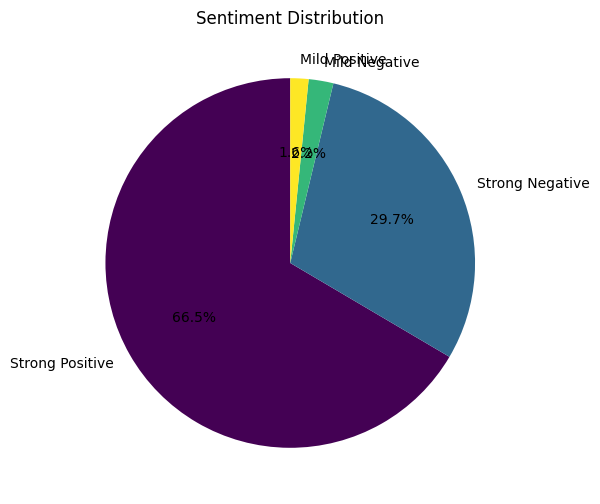

[*********************100%***********************]  1 of 1 completed



First 5 rows of Stock Prices data:
         Date  Adj Close  Close  High   Low  Open    Volume  SMA_20  SMA_50  \
49 2011-02-28       9.21   9.21  9.39  9.05  9.34  21558600  8.6105  8.3392   
50 2011-03-01       9.03   9.03  9.32  9.00  9.27  19415000  8.6705  8.3592   
51 2011-03-02       9.17   9.17  9.34  9.05  9.05  21253600  8.7180  8.3806   
52 2011-03-03       9.28   9.28  9.37  9.18  9.31  18762800  8.7675  8.4014   
53 2011-03-04       9.23   9.23  9.39  9.15  9.33  23059400  8.8125  8.4232   

      EMA_20        RSI  Price_Change  Volatility  
49  8.698730  64.193562     -0.008611    0.434709  
50  8.730280  62.382454     -0.019544    0.410944  
51  8.772158  64.156644      0.015504    0.381348  
52  8.820524  65.497077      0.011996    0.339838  
53  8.859521  63.929620     -0.005388    0.280890  

Last 5 rows of Stock Prices data:
           Date   Adj Close       Close        High         Low        Open  \
3499 2024-11-12  143.630005  143.630005  147.449997  141.550003

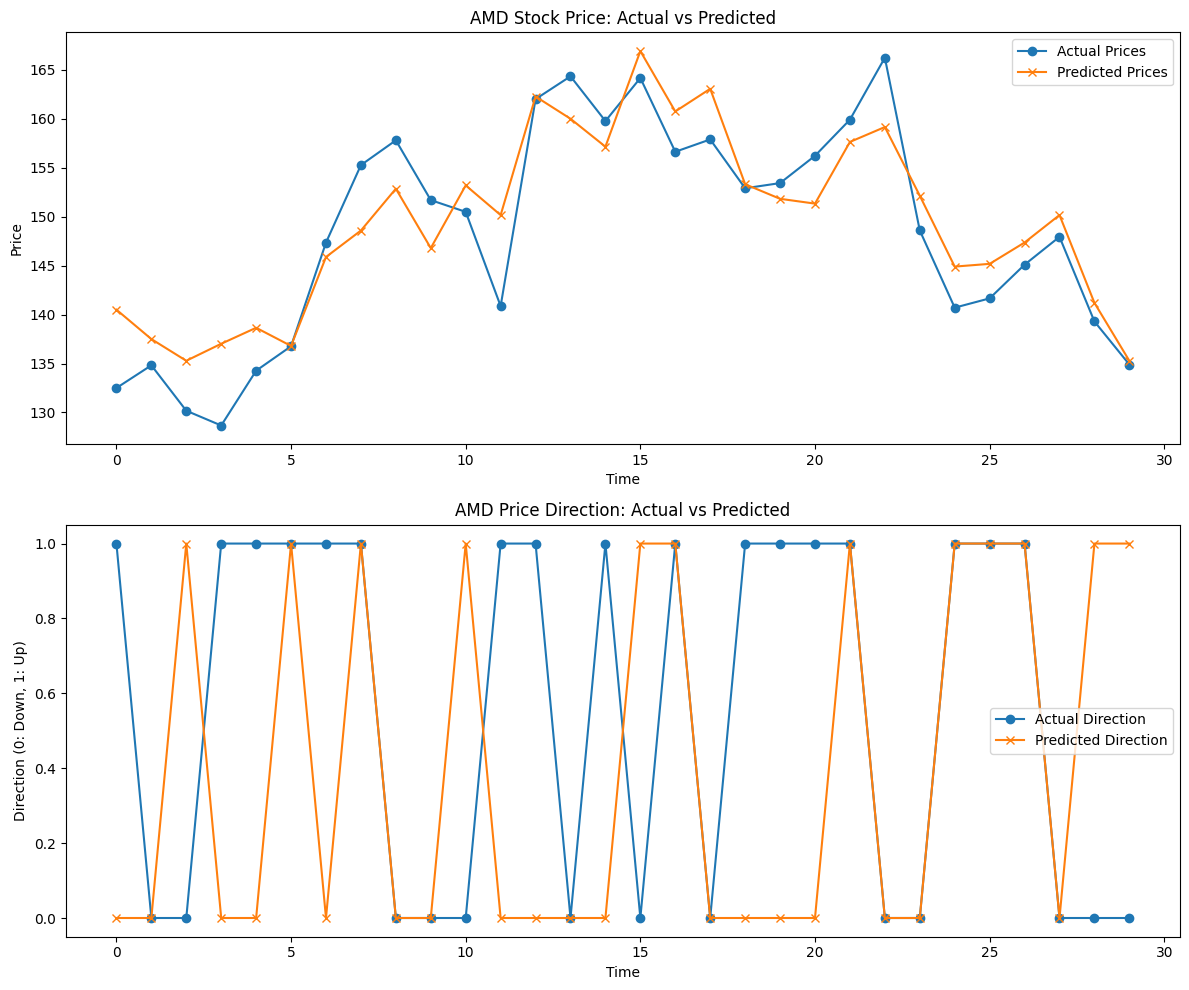


Regression Metrics:
MSE: 19.70157325595307
R2: 0.8366389510262449
MAE: 3.73843994140625

Classification Metrics:
Accuracy: 0.5

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.62      0.52        13
           1       0.58      0.41      0.48        17

    accuracy                           0.50        30
   macro avg       0.51      0.51      0.50        30
weighted avg       0.52      0.50      0.50        30



In [ ]:
import pandas as pd
import numpy as np
import nltk
import yfinance as yf
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report
import xgboost as xgb
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')


nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer

class AdvancedStockSentimentPredictor:
    def __init__(self, stock_symbol):
        self.stock_symbol = stock_symbol
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        self.transformer_sentiment = pipeline('sentiment-analysis')

    def preprocess_reddit_data(self, file_path):
        df = pd.read_csv(file_path)
        df['Datetime'] = pd.to_datetime(df['Datetime'])

        def advanced_text_cleaning(text):
            text = str(text).lower()
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            text = re.sub(r'[^a-zA-Z\s]', '', text)
            text = re.sub(r'\s+', ' ', text).strip()
            return text

        df['Cleaned_Discussion'] = df['Discussion'].apply(advanced_text_cleaning)

        df_grouped = df.groupby(df['Datetime'].dt.date).agg({
            'Cleaned_Discussion': ' '.join,
            'Discussion': 'count'
        }).reset_index()

        df_grouped.columns = ['Date', 'Full_Discussion', 'Discussion_Count']
        df_grouped['Date'] = pd.to_datetime(df_grouped['Date'])

        return df_grouped

    def advanced_sentiment_analysis(self, reddit_data):
        def multi_sentiment_score(text):
            vader_sentiment = self.sentiment_analyzer.polarity_scores(text)
            try:
                transformer_result = self.transformer_sentiment(text[:512])[0]
                transformer_score = 1 if transformer_result['label'] == 'POSITIVE' else -1
            except:
                transformer_score = 0

            return {
                'vader_compound': vader_sentiment['compound'],
                'transformer_sentiment': transformer_score,
                'negative': vader_sentiment['neg'],
                'neutral': vader_sentiment['neu'],
                'positive': vader_sentiment['pos']
            }

        sentiment_results = reddit_data['Full_Discussion'].apply(multi_sentiment_score).apply(pd.Series)
        reddit_data = pd.concat([reddit_data, sentiment_results], axis=1)

        def advanced_sentiment_categorization(row):
            weighted_score = (
                0.7 * row['vader_compound'] +
                0.3 * row['transformer_sentiment']
            )

            if weighted_score > 0.1:
                return 2  # Strong Positive
            elif weighted_score > 0:
                return 1  # Mild Positive
            elif weighted_score < -0.1:
                return -2  # Strong Negative
            elif weighted_score < 0:
                return -1  # Mild Negative
            else:
                return 0  # Neutral

        reddit_data['Sentiment_Score'] = reddit_data.apply(advanced_sentiment_categorization, axis=1)

        return reddit_data

    def fetch_advanced_stock_data(self, start_date, end_date):
        stock_data = yf.download(self.stock_symbol, start=start_date, end=end_date)
        stock_data = stock_data.reset_index()
        stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]
        stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.tz_localize(None)
        stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
        stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()
        stock_data['EMA_20'] = stock_data['Close'].ewm(span=20, adjust=False).mean()
        stock_data['RSI'] = self.calculate_rsi(stock_data['Close'])
        stock_data['Price_Change'] = stock_data['Close'].pct_change()
        stock_data['Volatility'] = stock_data['Close'].rolling(window=14).std()

        return stock_data.dropna()

    def calculate_rsi(self, prices, periods=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def prepare_ml_features(self, merged_data):
        features_columns = [
            'Discussion_Count', 'vader_compound', 'transformer_sentiment',
            'negative', 'positive', 'SMA_20', 'SMA_50', 'EMA_20',
            'RSI', 'Price_Change', 'Volatility'
        ]

        X = merged_data[features_columns]
        y_reg = merged_data['Close']


        merged_data['Price_Direction'] = (merged_data['Close'].shift(-1) > merged_data['Close']).astype(int)
        y_cls = merged_data['Price_Direction']

        return X, y_reg, y_cls

    def train_and_evaluate_model(self, X, y_reg, y_cls):
        X_train, X_test = X[:-30], X[-30:]
        y_reg_train, y_reg_test = y_reg[:-30], y_reg[-30:]
        y_cls_train, y_cls_test = y_cls[:-30], y_cls[-30:]
        reg_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', xgb.XGBRegressor(
                n_estimators=1000,
                learning_rate=0.01,
                max_depth=7,
                random_state=42
            ))
        ])

        cls_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('classifier', xgb.XGBClassifier(
                n_estimators=1000,
                learning_rate=0.01,
                max_depth=7,
                random_state=42,
                use_label_encoder=False,
                eval_metric='logloss'
            ))
        ])

        reg_pipeline.fit(X_train, y_reg_train)
        reg_predictions = reg_pipeline.predict(X_test)


        cls_pipeline.fit(X_train, y_cls_train)
        cls_predictions = cls_pipeline.predict(X_test)

        regression_metrics = {
            'MSE': mean_squared_error(y_reg_test, reg_predictions),
            'R2': r2_score(y_reg_test, reg_predictions),
            'MAE': mean_absolute_error(y_reg_test, reg_predictions)
        }

        classification_metrics = {
            'Accuracy': accuracy_score(y_cls_test, cls_predictions),
            'Classification_Report': classification_report(y_cls_test, cls_predictions)
        }

        self.visualize_predictions(y_reg_test, reg_predictions, y_cls_test, cls_predictions)

        return {
            'regression_model': reg_pipeline,
            'classification_model': cls_pipeline,
            'regression_predictions': reg_predictions,
            'classification_predictions': cls_predictions,
            'regression_metrics': regression_metrics,
            'classification_metrics': classification_metrics
        }

    def visualize_predictions(self, y_reg_test, reg_predictions, y_cls_test, cls_predictions):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

        ax1.plot(range(len(y_reg_test)), y_reg_test, label='Actual Prices', marker='o')
        ax1.plot(range(len(reg_predictions)), reg_predictions, label='Predicted Prices', marker='x')
        ax1.set_title(f'{self.stock_symbol} Stock Price: Actual vs Predicted')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Price')
        ax1.legend()

        ax2.plot(range(len(y_cls_test)), y_cls_test, label='Actual Direction', marker='o')
        ax2.plot(range(len(cls_predictions)), cls_predictions, label='Predicted Direction', marker='x')
        ax2.set_title(f'{self.stock_symbol} Price Direction: Actual vs Predicted')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Direction (0: Down, 1: Up)')
        ax2.legend()

        plt.tight_layout()
        plt.show()

def visualize_data(data, title, col_name):
    value_counts = data[col_name].value_counts()
    plt.figure(figsize=(8, 6))
    value_counts.plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
    plt.title(f"{title} Distribution")
    plt.ylabel('')
    plt.show()

def visualize_sentiment_distribution(sentiment_data):
    sentiment_mapping = {
        -2: "Strong Negative",
        -1: "Mild Negative",
        0: "Neutral",
        1: "Mild Positive",
        2: "Strong Positive"
    }
    sentiment_data['Sentiment_Label'] = sentiment_data['Sentiment_Score'].map(sentiment_mapping)
    visualize_data(sentiment_data, "Sentiment", "Sentiment_Label")

def visualize_discussion_count(reddit_data):
    plt.figure(figsize=(10, 6))
    plt.plot(reddit_data['Date'], reddit_data['Discussion_Count'], label='Discussion Count', color='orange')
    plt.title("Discussion Count Over Time")
    plt.xlabel("Date")
    plt.ylabel("Number of Discussions")
    plt.legend()
    plt.show()

def show_head_tail(data, dataset_name):
    print(f"\nFirst 5 rows of {dataset_name} data:")
    print(data.head())
    print(f"\nLast 5 rows of {dataset_name} data:")
    print(data.tail())

def main():
    stock_symbol = 'AMD'
    predictor = AdvancedStockSentimentPredictor(stock_symbol)
    reddit_csv_path = '/content/reddit_stock_raw.csv'

    preprocessed_reddit = predictor.preprocess_reddit_data(reddit_csv_path)
    show_head_tail(preprocessed_reddit, "Reddit")
    visualize_discussion_count(preprocessed_reddit)

    sentiment_data = predictor.advanced_sentiment_analysis(preprocessed_reddit)
    show_head_tail(sentiment_data, "Sentiment")
    visualize_sentiment_distribution(sentiment_data)

    start_date = sentiment_data['Date'].min().strftime('%Y-%m-%d')
    end_date = sentiment_data['Date'].max().strftime('%Y-%m-%d')
    stock_prices = predictor.fetch_advanced_stock_data(start_date, end_date)
    show_head_tail(stock_prices, "Stock Prices")

    merged_data = pd.merge(sentiment_data, stock_prices, on='Date', how='inner')
    X, y_reg, y_cls = predictor.prepare_ml_features(merged_data)

    results = predictor.train_and_evaluate_model(X, y_reg, y_cls)

    print("\nRegression Metrics:")
    for metric, value in results['regression_metrics'].items():
        print(f"{metric}: {value}")

    print("\nClassification Metrics:")
    print(f"Accuracy: {results['classification_metrics']['Accuracy']}")
    print("\nDetailed Classification Report:")
    print(results['classification_metrics']['Classification_Report'])

if __name__ == "__main__":
    main()